## 4.1.1 逻辑回归
逻辑回归(Logistic Regression)，虽然名字里有 “回归” 二字，但实际上是解决分类问题的一类线性模型，主要用于二分类问题。

由于分类问题中标签的取值是离散的 0 和 1，线性回归的目标函数取值并不在 (0, 1) 之间，需要用 sigmoid 函数归一化。sigmoid 函数如下：

$$ h_\theta(X)=g(z) = \frac {1}{1+exp^{-z}}$$
$$z = \theta^T X = \theta_0 + \sum_{j=1}^n\theta_jx_j$$

根据极大似然估计 (MLE)，得到逻辑回归的损失函数：

$$
\begin{aligned}
\ell(\theta) &=\log L(\theta) \\
&=\sum_{i=1}^{m} y^{(i)} \log h\left(x^{(i)}\right)+\left(1-y^{(i)}\right) \log \left(1-h\left(x^{(i)}\right)\right)
\end{aligned}
$$

求梯度：

$$ \frac{\partial\ell(\theta)}{\partial\theta_j} =-\frac{1}{m}\sum_{i=1}^m(y^{(i)}h_\theta(x^{(i)}))x_j^{(i)}$$

梯度更新：

$$ \theta_j := \theta_j - \alpha\sum_{i=1}^m(h_\theta(x^{(i)}-y^{(i)}))x_j^{(i)}   $$

### 4.1.1.1 API
**sklearn.linear_model.LogisticRegression**

#### 4.1.1.1.1 属性
sklearn.linear_model.LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)

- penalty='l2' : 字符串‘l1’或‘l2’,默认‘l2’。用来指定惩罚的基准（正则化参数）。只有‘l2’支持‘newton-cg’、‘sag’和‘lbfgs’这三种算法。
如果选择‘l2’，solver参数可以选择‘liblinear’、‘newton-cg’、‘sag’和‘lbfgs’这四种算法；如果选择‘l1’的话就只能用‘liblinear’算法。

- dual=False : 对偶或者原始方法。Dual只适用于正则化相为l2的‘liblinear’的情况，通常样本数大于特征数的情况下，默认为False。
- C=1.0 : C为正则化系数$\lambda$的倒数，必须为正数，默认为1。和SVM中的C一样，值越小，代表正则化越强。
- fit_intercept=True : 是否存在截距，默认存在。
- intercept_scaling=1 : 仅在正则化项为‘liblinear’，且fit_intercept设置为True时有用。
- solver='liblinear' : solver参数决定了我们对逻辑回归损失函数的优化方法，有四种算法可以选择。
  - a) liblinear：使用了开源的liblinear库实现，内部使用了坐标轴下降法来迭代优化损失函数。
  - b) lbfgs：拟牛顿法的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。
  - c) newton-cg：也是牛顿法家族的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。
  - d) sag：即随机平均梯度下降，是梯度下降法的变种，和普通梯度下降法的区别是每次迭代仅仅用一部分的样本来计算梯度，适合于样本数据多的时候。

从上面的描述可以看出，newton-cg、lbfgs 和 sag 这三种优化算法时都需要损失函数的一阶或者二阶连续导数，因此不能用于没有连续导数的 L1 正则化，只能用于L2 正则化。而 liblinear 可以用 L1正则化和L2正则化。

同时，sag 每次仅仅使用了部分样本进行梯度迭代，所以当样本量少的时候不要选择它，而如果样本量非常大，比如大于 10 万，sag 是第一选择。但是 sag 不能用于L1 正则化，所以当你有大量的样本，又需要 L1 正则化的话就要自己做取舍了。要么通过对样本采样来降低样本量，要么回到 L2 正则化。

对于多元逻辑回归常见的有 one-vs-rest(OvR) 和 many-vs-many(MvM) 两种。而 MvM 一般比 OvR分 类相对准确一些。liblinear 只支持 OvR ，不支持 MvM ，这样如果我们需要相对精确的多元逻辑回归时，就不能选择 liblinear了。也意味着如果我们需要相对精确的多元逻辑回归不能使用 L1 正则化了。

**总结：**

|正则化|算法|适用场景|
|----|----|----|
|L1	|liblinear|	liblinear适用于小数据集；如果选择L2正则化发现还是过拟合，即预测效果差的时候，就可以考虑L1正则化；如果模型的特征非常多，希望一些不重要的特征系数归零，从而让模型系数稀疏化的话，也可以使用L1正则化。|
|L2	|liblinear|	libniear只支持多元逻辑回归的OvR，不支持MvM，但MVM相对精确。|
|L2	|lbfgs/newton-cg/sag|	较大数据集，支持one-vs-rest(OvR)和many-vs-many(MvM)两种多元逻辑回归。|
|L2	|sag|	如果样本量非常大，比如大于10万，sag是第一选择；但不能用于L1正则化。|

- multi_class='ovr' : 分类方式，有两种：ovr 即 one-vs-rest(OvR)，multinomial 是 many-vs-many(MvM)。如果是二元逻辑回归，ovr 和 multinomial 并没有任何区别，区别主要在多元逻辑回归上。ovr 不论是几元回归，都当成二元回归来处理。mvm 从从多个类中每次选两个类进行二元回归。如果总共有T类，需要T(T-1)/2次分类。
OvR 相对简单，但分类效果相对略差（大多数样本分布情况）； MvM 分类相对精确，但是分类速度没有 OvR 快。如果选择了ovr，则4种损失函数的优化方法liblinear,newton-cg,lbfgs,sag 都可以选择。但是如果选择了 multinomial,则只能选择 newton-cg, lbfgs, sag。
- class_weight=None : 类型权重参数。用于标示分类模型中各种类型的权重。默认不输入，即所有的分类的权重一样。选择‘balanced’自动根据y值计算类型权重。自己设置权重，格式：{class_label: weight}。例如0,1分类的二元模型，设置class_weight={0:0.9, 1:0.1}，这样类型0的权重为90%，而类型1的权重为10%。
- random_state=None : 随机数种子，默认为无。仅在正则化优化算法为 sag,liblinear 时有用。
- max_iter=100 : 算法收敛的最大迭代次数。
- tol=0.0001 : 迭代终止判据的误差范围。
- verbose=0 : 日志冗长度 int：冗长度；0：不输出训练过程；1：偶尔输出； >1：对每个子模型都输出
- warm_start=False : 是否热启动，如果是，则下一次训练是以追加树的形式进行（重新使用上一次的调用作为初始化）。布尔型，默认False。
- n_jobs=1 : 并行数，int：个数；-1：跟CPU核数一致；1:默认值。

#### 4.1.1.1.2 方法
- fit(X, y, sample_weight=None)：
拟合模型，用来训练LR分类器，其中X是训练样本，y是对应的标记向量
返回对象，self。
- fit_transform(X, y=None, **fit_params)：
fit与transform的结合，先fit后transform。返回X_new:numpy矩阵。
- predict(X)：
用来预测样本，也就是分类，X是测试集。返回array。
- predict_proba(X)：
输出分类概率。返回每种类别的概率，按照分类类别顺序给出。如果是多分类问题，multi_class="multinomial"，则会给出样本对于每种类别的概率。
返回array-like。
- score(X, y, sample_weight=None)：
返回给定测试集合的平均准确率（mean accuracy），浮点型数值。
对于多个分类返回，则返回每个类别的准确率组成的哈希矩阵。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

iris = datasets.load_iris()

X = iris.data[:, :2]  # 选择前2个特征
Y = iris.target
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
# OVR方式的默认调用
lr = LogisticRegression(C=1e5)

# 训练
lr.fit(x_train, y_train)
lr.score(x_train, y_train)

In C:\Users\xingc\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\xingc\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\xingc\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\xingc\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\xingc\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

0.825

In [2]:
# 测试
y_preict = lr.predict(x_test)
acc =  lr.score(x_test, y_test)
acc

0.8333333333333334

In [3]:
lr.coef_, lr.intercept_, y_train

(array([[-36.50036081,  30.78933832],
        [ 17.3540191 , -15.67705382],
        [ 19.14634171, -15.1122845 ]]),
 array([ 98.78238599, -43.01907136, -55.76331462]),
 array([1, 0, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0,
        2, 1, 2, 2, 1, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2,
        2, 2, 0, 1, 1, 0, 1, 0, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 2, 0, 0, 2,
        0, 2, 0, 2, 1, 1, 0, 2, 1, 0, 1, 2, 0, 0, 1, 2, 2, 1, 2, 0, 1, 2,
        2, 1, 0, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 0, 2, 2, 0, 2, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 2, 1]))

In [4]:
def plot_decision_boundary(model, X):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 2
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 2
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    x_new = np.c_[xx.ravel(), yy.ravel()]
    y_pre = model.predict(x_new)
    zz = y_pre.reshape(xx.shape)
    from matplotlib.colors import ListedColormap
    cus=ListedColormap(["#EF9A9A","#FFF59D","#90CAF9"])
    plt.contourf(xx, yy, zz, cmap=cus)
    

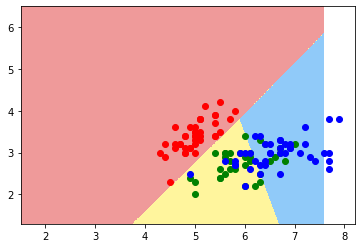

In [5]:
plot_decision_boundary(lr, x_train)
plt.scatter(x_train[y_train==0,0],x_train[y_train==0,1],color="r")
plt.scatter(x_train[y_train==1,0],x_train[y_train==1,1],color="g")
plt.scatter(x_train[y_train==2,0],x_train[y_train==2,1],color="b")
plt.show()

0.8333333333333334


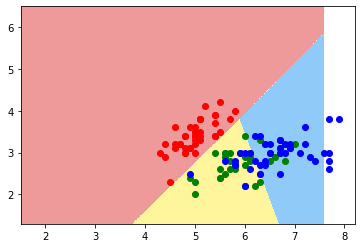

In [6]:
# OVO的方式调用
lr1=LogisticRegression(multi_class="multinomial",solver="newton-cg", C=1e5)
lr1.fit(x_train,y_train)
print(lr1.score(x_test,y_test))
plot_decision_boundary(lr1,x_train)
plt.scatter(x_train[y_train==0,0],x_train[y_train==0,1],color="r")
plt.scatter(x_train[y_train==1,0],x_train[y_train==1,1],color="g")
plt.scatter(x_train[y_train==2,0],x_train[y_train==2,1],color="b")
plt.show()

In [7]:
y_preict = lr1.predict(x_test)
acc =  lr1.score(x_test, y_test)
acc

0.8333333333333334


## 4.1.2 决策树
决策树（Decision Tree）是一种非参数的有监督学习方法，它能够从一系列有特征和标签的数据中总结出决策规则，并用树状图的结构来呈现这些规则，以解决分类和回归问题。
决策树比较适合分析离散数据，如果是连续数据要先转成离散数据再做分析。



### 4.1.2.1 API
```python
sklearn.tree.DecisionTreeClassifier(
    *, 
    criterion='gini',  # "gini"或者"entropy"，前者代表基尼系数，后者代表信息增益。
    splitter='best',  # splitte：特征划分标准，'best' or 'random' (default='best') ，前者在特征的所有划分点中找出最优的划分点。后者是随机的在部分划分点中找局部最优的划分点。 默认的'best'适合样本量不大的时候，如果样本数据量非常大，此时推荐 random 。
    max_depth=None,  # 用于控制决策树的最大深度 maximum_depth，一般来说，数据少或者特征少的时候可以不管这个值。如果样本量多，特征也多的情况下，推荐限制这个最大深度。常用的可以取值10-100之间。常用来解决过拟合
    min_samples_split=2,  # 一个节点在被分割前必须拥有的最小样本数
    min_samples_leaf=1,  # 叶子节点必须拥有的最小样本数
    min_weight_fraction_leaf=0.0,  # 叶子节点必须拥有的最小样本数与总样本数之比
    max_features=None,  # 用于每个节点进行分割的最大特征数
    random_state=None, 
    max_leaf_nodes=None,  # 叶子节点必须拥有的最大样本数
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    class_weight=None, 
    ccp_alpha=0.0
)
```
更多内容参考：https://blog.csdn.net/qq_30815237/article/details/89218316

In [8]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()  # 加载数据

In [9]:
x = iris.data[:, 2:]  # 选择最后两列特征作为训练样本
y = iris.target  # 获取训练集的标签

decision_tree_classifier = DecisionTreeClassifier(max_depth=2)
decision_tree_classifier.fit(x, y)

DecisionTreeClassifier(max_depth=2)

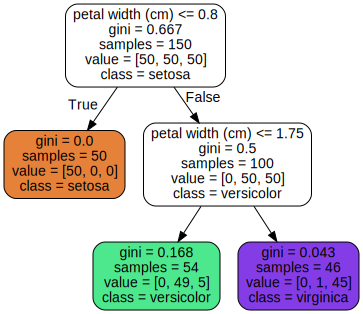

In [10]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
    decision_tree_classifier,
    out_file='iris_tree.dot',
    feature_names = iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
    
)

Source.from_file('iris_tree.dot')

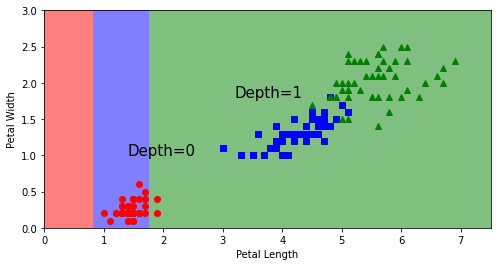

In [11]:
# 绘制决策边界

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(classifier, x, y, axs=[0, 7.5, 0, 3]):
    # 1. 画出网格
    xx1 = np.linspace(axs[0], axs[1], 100)
    xx2 = np.linspace(axs[2], axs[3], 100)
    x1, x2 = np.meshgrid(xx1, xx2)
    x_new = np.array([x1.ravel(), x1.ravel()]).T
    # 2. 算出网格中各个点的预测结果(x1.shape=(100, 100))
    y_predict = classifier.predict(x_new).reshape(x1.shape)
    # 3. 为不同的类分配不同的颜色
    colors = ['red', 'blue', 'green', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    plt.contourf(x1, x2, y_predict, alpha=0.5, cmap=cmap)
    # 4. 画出训练样本，需要将 draw_train 指定为 True
    plt.plot(x[:,0][y==0], x[:,1][y==0], 'ro', label='iris setosa')
    plt.plot(x[:,0][y==1], x[:,1][y==1], 'bs', label='iris versicolor')
    plt.plot(x[:,0][y==2], x[:,1][y==2], 'g^', label='iris virginica')
    
    # 给坐标添加标签    
    plt.xlabel('Petal Length')
    plt.ylabel('Petal Width')

plt.figure(figsize=(8, 4))
plot_decision_boundary(decision_tree_classifier, x, y)

plt.text(1.40, 1.0, 'Depth=0', fontsize=15)
plt.text(3.20, 1.80, 'Depth=1', fontsize=15)

plt.show()

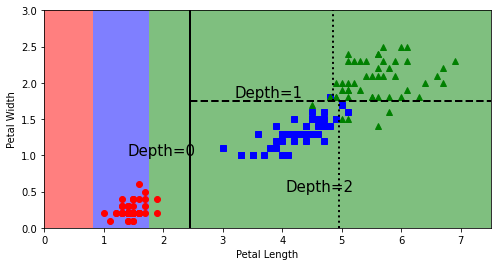

In [12]:
# 模拟 max_depth = 3
plt.figure(figsize=(8, 4))
plot_decision_boundary(decision_tree_classifier, x, y)
plt.plot([2.45, 2.45], [0, 3], 'k-', linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], 'k--', linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], 'k:', linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], 'k:', linewidth=2)

plt.text(4.05, 0.5, 'Depth=2', fontsize=15)


plt.text(1.40, 1.0, 'Depth=0', fontsize=15)
plt.text(3.20, 1.80, 'Depth=1', fontsize=15)

plt.show()

## 4.1.3 支持向量机



## 4.1.4 朴素贝叶斯


